# Laboratorium

### Konfiguracja

In [4]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
from random import *
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [5]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

### Reprezentacja punktów i odcinków, oraz funkcje pomocnicze

In [6]:
#klasa wykorzystywane do reprezentowania zdarzeń na których zatrzymuje się miotła (punktów)
#oraz klasa reprezenująca odcinki

#klasa ta wykorzystwana jest do reprezentowania punktów
class Vector2d:
    #konstruktor klasy punkt
    #punkt jest opisywany przez
    def __init__(self,x,y,event=None):
        #współrzędna x-owa
        self.x =x
        #współrzędnay-kowa
        self.y =y
        #zdarzenie któremu odpowiada (początek lini / koniec lini / przecięcie lini)
        self.event = event
        # id lini które ewentualnie przecinają się w punkcie
        self.firstLineId = None
        self.secondLineId = None
    #ustawia punkt jako odpowiadający za event początku wierzchołka
    def setAsStart(self,lineID):
        self.event = "start"
        self.lineId = lineID
    #ustawia punkt jako odpowiadający za event końca wierzchołka
    def setAsEnd(self,lineID):
        self.event = "end"
        self.lineId = lineID
    #ustawia punkt jako odpowiadający za event przecięcia odcinków
    #i przypisuje mu id odcinków które przecinają się w tym punkcie
    def SetAsIntersect(self,Id1,Id2):
        self.event = "intersect"
        self.firstLineId = Id1
        self.secondLineId = Id2
    #porównywanie wierzchołków narpierw po x potem po y
    def __gt__(self,other):
        return self.toTuple() > other.toTuple()
    #reprentacja punktu jako tupli współżędnych
    def toTuple(self):
        return (self.x,self.y)
    #pozwala na wypisanie punktu funkcją print
    def __str__(self):
            return str(self.toTuple())
    #ustawia precyzje klasy point
    #(precyzja jest wykorzystywana przy liczeniu)
    def setPrec(epsilon = 1e-12):
        Vector2d.prec = epsilon
    #oblicza wyznacznik macierzy 3x3
    def det(self,b,c):
        res = self.x*b.y+self.y*c.x+b.x*c.y-(c.x*b.y+self.y*b.x+self.x*c.y)
        if  -Vector2d.prec<res<Vector2d.prec :
            return 0
        else:
            return res
    #porównuje punkty, w przypadku gdy opisują one punkt przecięcia na podstawie lini, które
    #przecinają się w tym punkcie dzięki czemu, punkt przecięcia dwóch odcinków nie zostanie
    #dodany do rozwiązania dwa razy
    def __eq__(self,other):
        if self.event == "intersect":
            return (self.firstLineId in [other.firstLineId,other.secondLineId]
                    and self.secondLineId in [other.firstLineId,other.secondLineId])
        else:
            return ((self.x == other.x and self.y == other.y)
                and (self.event == other.event) 
                and (other.firstLineId in [self.firstLineId,self.secondLineId])
                and (other.secondLineId in [self.firstLineId,self.secondLineId]))
    #haszowanie punktu umożliwiające przechowywanie go w secie
    #wykorzystywane tylko dla punktów przecięcia
    def __hash__(self):
        asString =str(self.event) + str(self.firstLineId*17389+self.secondLineId*17389)
        return hash(asString)
#klasa opisująca odcinek
class Line:
    #wierzchołkek początkowy i końcowy przechowujemy jako obiekty typu Vector2d
    #odcinkek przechowuje poza końcem i początkiem odcinka, informacje na temat
    #prostej na której się znajduje współczynnik kierunkowy a, i stałą b
    #(równanie prostej ax+b)
    def __init__(self,point1,point2):
        if type(point1) == tuple:
            point1 = Vector2d(*point1)
        if type(point2) == tuple:
            point2 = Vector2d(*point2,)
        self.start = point1
        self.start.setAsStart(None)
        self.end = point2
        self.end.setAsEnd(None)
        self.a = (self.end.y - self.start.y) / (self.end.x - self.start.x)
        self.b = self.start.y - self.a*self.start.x
    #reprezentacja lini jako string 
    def __str__(self):
        return str(self.start) + " " + str(self.end) + " "+str(self.a) + " "+str(self.b)
    #ustawaia aktualny x, na podstawie którego obliczana jest wartość y-kowej współżędnej odcinka
    #przy wywołaniu komparatora
    def setActualX(x):
        Line.actualX = x
    #komparator odcinków, porównujący współżędną y w ustalonym x
    def __gt__(self,other):
        return self.a*Line.actualX+self.b > other.a*Line.actualX+other.b
    #porównanie róności odcinków
    def __eq__(self,other):
        return self.start == other.start and self.end == other.end
    #sprawdzenie czy dwa odcinki się przecinają, zwraca prawdę/fałsz
    def areIntersect(self,other,epsilon = 1e-10):
        def onSegment(x,y,z):
            return min(x.x,y.x) <= z.x and z.x <= max(x.x,y.x) and min(x.y,y.y) <= z.y and z.y <= max(x.y,y.y)
        Vector2d.setPrec(epsilon)
        p1 = self.start
        p2 = self.end
        p3 = other.start
        p4 = other.end
        d1=p3.det(p4,p1)
        d2=p3.det(p4,p2)
        d3=p1.det(p2,p3)
        d4=p1.det(p2,p4)
        if ((d1>0 and d2<0) or (d1<0 and d2>0)) and ((d3>0 and d4<0) or (d3<0 and d4>0)):
            return True
        if (d1 == 0) and onSegment(p3,p4,p1):
            return True
        if (d2 == 0) and onSegment(p3,p4,p2):
            return True
        if (d3 == 0) and onSegment(p1,p2,p3):
            return True
        if (d4 == 0) and onSegment(p1,p2,p4):
            return True
        return False  
    #reprezentacja odcinka jako pary dwóch punktów
    def toTuple(self):
        return (self.start.toTuple(),self.end.toTuple())
#funkcja która po sprawdzeniu metotą areIntersect czy odcinki się przecinają, zwraca współżędne
#punktu przecięcia, i ustawia zwróconemu punktowi reprezentowane przez niego zdażenie jako
#przecięcie, oraz przypisuje do niego proste które przecinają się w tym punkcie
def intersectPoint(lines,id1,id2):
    x = (lines[id2].b - lines[id1].b)/(lines[id1].a - lines[id2].a)
    resultPoint = Vector2d(x,lines[id1].a*x+lines[id1].b)
    resultPoint.SetAsIntersect(id1,id2)
    return resultPoint

### Wizualizacja

In [7]:
#funkcja umożliwiająca wizualizacje działanie zamiatania
#przechwytuje jedną klatkę animacji i zapisuje ją jako scene
#zbierane informacje to: aktualnie aktywne odcinki, już użyte punkty,dodane punkty przecięcia
#położenie miotły
def getFrame(points,lines,active,used,x=None,scenes=None):
    used = used[:]
    active = [i[1] for i in active]
    defaultPoints = PointsCollection([(0,0),(1000,1000)],color="white")
    points = points[:]
    if x:
        #minY = min(points,key = lambda point : point.y)
        #maxY = max(points,key = lambda point : point.y)
        broom = [(x,0),(x,1000)]
    if scenes==None:
        scenes=[]
    start = []
    end = []
    intersect = []
    active = [lines[i].toTuple() for i in active]
    lines = [i.toTuple() for i in lines]
    for i in points:
        if i.event == 'end':
            end.append(i.toTuple())
        if i.event == 'start':
            start.append(i.toTuple())
        if i.event == 'intersect':
            intersect.append(i.toTuple())
    if x:
        scene = Scene(points=[PointsCollection(used,color="grey"),defaultPoints,PointsCollection(start,color = "green"),PointsCollection(end,color = "red"),PointsCollection(intersect,color = "darkmagenta",marker="D")],
                  lines = [LinesCollection(lines,color = "black"),LinesCollection(active,color = "limegreen"),LinesCollection([broom],color = "red")])
    else:
        scene = Scene(points=[defaultPoints,PointsCollection(start,color = "green"),PointsCollection(end,color = "red"),PointsCollection(intersect,color = "darkmagenta",marker="D")],
                  lines = [LinesCollection(lines,color = "black"),LinesCollection(active,color = "limegreen")])
    scenes.append(scene)
    return scenes

### Generowanie odcinków, pobieranie odcinków i inne

In [16]:
#pobranie odcinków wprowadzonych przez urzytkownika
def getLines(plot):
    lines = []
    for i in plot.get_added_lines():
        for j in i.lines:
            lines.append(j)
    lines = pointsForLinePreparation(lines)
    lines = [Line(*i) for i in lines]
    return lines
#sprawdzanie czy odcinek jest pionowy z dokładnością do epsilon
def idVertical(line,epsilon=1e-10):
    return line[1][0]-epsilon < line[0][0] < line[1][0]+epsilon
#generowanie losowych odcinków, przy wyeliminowaniu odcinków pionowych
#i tych stykających się końcami
def generateLines(n,leftBottomCorner,rightTopCorner):
    xCoordinates = set()
    yCoordinates = set()
    while len(xCoordinates) < 2*n:
        xCoordinates.add(uniform(leftBottomCorner.x,rightTopCorner.x))
    while len(yCoordinates) < 2*n:
        yCoordinates.add(uniform(leftBottomCorner.y,rightTopCorner.y))
    result = []
    for x,y in zip((xCoordinates),yCoordinates):
        result.append((x,y))
    lines = []
    line = []
    counter = 0
    for i in result:
        line.append(i)
        if counter % 2 == 1:
            counter = -1
            line = [min(line),max(line)]
            lines.append(line)
            line=[]
        counter+=1
    lines = [Line(*i) for i in lines]
    return lines
#towrzenie punktów reprezentujących końće i początki odcinków na podstawi listy odcinków
def pointsFromLines(lines):
    res = []
    for index,i in enumerate(lines):
        startPoint = i.start
        startPoint.setAsStart(index)
        endPoint = i.end
        endPoint.setAsEnd(index)
        res.append(startPoint)
        res.append(endPoint)
    return res
#ustawienie, aby początek odcinka był zawsze przed końcem
#(urzywane dla odcinków wprowadzanych ręcznie)
def pointsForLinePreparation(points):
    res = []
    for i in points:
        res.append((min(i,key = lambda point : point[0]),max(i,key = lambda point : point[0])))
    return res
#wypisywanie lini w tabeli w celu ich identyfikacji
def linesInTable(lines):
    columns = ["ID","współczynnik kierunkowy","b","punkt startu","punkt końca"]
    data = []
    for id,i in enumerate(lines):
        tmp =[]
        tmp.append(id)
        tmp.append(i.a)
        tmp.append(i.b)
        tmp.append(i.start.toTuple())
        tmp.append(i.end.toTuple())
        data.append(tmp)
    table = pd.DataFrame(data,columns=columns)
    return table
def crossPointsTable(points):
    columns = ["X","Y","ID Pierwszego odcinka","ID drugiego odcinka"]
    data = []
    for i in points:
        tmp = []
        tmp.append(i.x)
        tmp.append(i.y)
        tmp.append(i.firstLineId)
        tmp.append(i.secondLineId)
        data.append(tmp)
    table = pd.DataFrame(data,columns=columns)
    return table
        

### Funkcja sprawdzająca czy w zbiorze odcinków jakiekolwiek dwa się przecinają

In [9]:
#funckja wykorzystująca zamiatanie do sprawdzenia przecinania się dowolnych dwóch odcinkó
#floaga visualise odpowiada za wizualizacje
def anyIntersect(lines,visualise = True,epsilon = 1e-10):
    #import struktury przechowującej aktywne odcinki
    from blist import sortedset   
    #struktura stanów reprezentowana jako lista
    eventsStructure = []
    #struktura stanów reorezentowana jako sorted set
    stateStructure = sortedset()
    #dodaje początki i końce odcinków do struktury zdazeń i sortujemy punkty względem x
    #nastpępnie odwracamy posortowanie, aby móc pobierać pliki z końca w odpowiedniej kolejności
    # pop w pythonie ma złożoność O(1)
    eventsStructure = sorted(pointsFromLines(lines),key = lambda points: points.x,reverse=True)
    if visualise:
        scenes=[]
        used = []
        getFrame(eventsStructure,lines,stateStructure,[],scenes = scenes)
    #iteracja po odcinkach odbywa się dopóki nie przeszliśmy przez wszystkie punkty
    while len(eventsStructure) > 0:
        #pobieramy punkt do rozpatrzenia
        actualPoint = eventsStructure.pop()
        Line.setActualX(actualPoint.x)
        if visualise:
            getFrame(eventsStructure,lines,stateStructure,used,Line.actualX,scenes)
        #rozpatrujemy z jakim eventem mamy doczynienia
        #jeśli jest to początek odcinka
        if actualPoint.event == 'start':
            #dodajemy odcinek do struktury stanów
            stateStructure.add((lines[actualPoint.lineId],actualPoint.lineId))
            #pobieramy id odcinka z struktury stanów
            idInState = stateStructure.index((lines[actualPoint.lineId],actualPoint.lineId))
            #Sprawdzamy czy nowo dodany odcinek nie przecina się z swoim lewym sąsiadem
            #w struktórze stanów
            idNeighbor = idInState-1
            #narpierw upewniamy się czy lewy sąsiad istnieje
            #jeśli przecięcie istnieje kończymy działanie programu
            if idNeighbor >= 0:
                if stateStructure[idInState][0].areIntersect(stateStructure[idNeighbor][0]):
                    if visualise:
                        crossPoint = intersectPoint(lines,stateStructure[idInState][1],stateStructure[idNeighbor][1])
                        eventsStructure.append(crossPoint)
                        getFrame(eventsStructure,lines,stateStructure,used,Line.actualX,scenes)
                        return True,scenes
                    return True
            #robimy to samo dla prawego sąsiada
            idNeighbor +=2
            if idNeighbor >= 0 and idNeighbor < len(stateStructure):
                if stateStructure[idInState][0].areIntersect(stateStructure[idNeighbor][0]):
                    if visualise:
                        crossPoint = intersectPoint(lines,stateStructure[idInState][1],stateStructure[idNeighbor][1])
                        eventsStructure.append(crossPoint)
                        getFrame(eventsStructure,lines,stateStructure,used,Line.actualX,scenes)
                        return True,scenes
                    return True
        #rozpatrujemy event końca odcinka
        if actualPoint.event == 'end':
            #pobieramy id kończącego się odcinka z struktury stanów
            actualLineId = stateStructure.index((lines[actualPoint.lineId],actualPoint.lineId))
            #obliczmy id jego sąsiadów
            prevNeighborID = actualLineId-1
            nextNeighborID = actualLineId+1
            #sprawdzamy czy obaj sąsiedzi istnieją
            #sprawdzamy czy sąsiedzi nie przecinają się
            #i jeśli tak kończymy działanie programu
            if prevNeighborID >= 0 and nextNeighborID < len(stateStructure):
                if stateStructure[prevNeighborID][0].areIntersect(stateStructure[nextNeighborID][0]):
                    if visualise:
                        crossPoint = intersectPoint(lines,stateStructure[prevNeighborID][1],stateStructure[nextNeighborID][1])
                        eventsStructure.append(crossPoint)
                        getFrame(eventsStructure,lines,stateStructure,used,Line.setActualX,scenes)
                        return True,scenes
                    return True
            #usuwamy kończący się odcinek z struktury stanów
            del stateStructure[actualLineId]
        if visualise:
            used.append(actualPoint.toTuple())
    #jeżeli żadne dwa się nie przecinały to zwracamy fałsz
    if visualise:
        return False,scenes
    return False

### Funkcja sprawdzająca wszystkie przecięcia pomiędzy odcinkami

In [10]:
#funkcja analigoczna do tej sprawdzjącej istenienie dowlonego przecięcia
#różni się struktórom wydarzeń, oraz rozpatrywaniem eventu przecięcia odcinów
def allIntersect(lines,visualise = True,epsilon = 1e-10):
    from blist import sortedset
    #struktura która przechowuje eventy umożliwia teraz wstawianie nowego eventu
    #bez utraty posortowania, i robi to w dobrym czasie
    eventsStructure = sortedset()
    for i in pointsFromLines(lines):
        eventsStructure.add(i)
    stateStructure = sortedset()
    #struktóra przechowująca punkty przecięcia, wybrany został set, dzięki czemu eliminowane są
    #ewnentualne powtóżenia
    resultIntersections = set()
    if visualise:
        scenes=[]
        used = []
        getFrame(eventsStructure,lines,stateStructure,[],scenes = scenes)
    while len(eventsStructure) > 0:
        actualPoint = eventsStructure.pop(0)
        if visualise:
            getFrame(eventsStructure,lines,stateStructure,used[:],actualPoint.x,scenes)
        if actualPoint.event == 'start':
            Line.setActualX(actualPoint.x)
            stateStructure.add((lines[actualPoint.lineId],actualPoint.lineId))
            idInState = stateStructure.index((lines[actualPoint.lineId],actualPoint.lineId))
            idNeighbor = idInState-1
            if idNeighbor >= 0:
                if stateStructure[idInState][0].areIntersect(stateStructure[idNeighbor][0]):
                    if visualise:
                        crossPoint = intersectPoint(lines,stateStructure[idInState][1],stateStructure[idNeighbor][1])
                        if crossPoint not in resultIntersections:
                            eventsStructure.add(crossPoint)
                        if visualise:
                            getFrame(eventsStructure,lines,stateStructure,used,actualPoint.x,scenes)
            idNeighbor +=2
            if idNeighbor >= 0 and idNeighbor < len(stateStructure):
                if stateStructure[idInState][0].areIntersect(stateStructure[idNeighbor][0]):
                    if visualise:
                        crossPoint = intersectPoint(lines,stateStructure[idInState][1],stateStructure[idNeighbor][1])
                        if crossPoint not in resultIntersections:
                            eventsStructure.add(crossPoint)
                        if visualise:
                            getFrame(eventsStructure,lines,stateStructure,used,actualPoint.x,scenes)
        if actualPoint.event == 'end':
            if (lines[actualPoint.lineId],actualPoint.lineId) in stateStructure:
                actualLineId = stateStructure.index((lines[actualPoint.lineId],actualPoint.lineId))
                prevNeighborID = actualLineId-1
                nextNeighborID = actualLineId+1
                if prevNeighborID >= 0 and nextNeighborID < len(stateStructure):
                    if stateStructure[prevNeighborID][0].areIntersect(stateStructure[nextNeighborID][0]):
                        crossPoint = intersectPoint(lines,stateStructure[prevNeighborID][1],stateStructure[nextNeighborID][1])
                        if crossPoint not in resultIntersections:
                            eventsStructure.add(crossPoint)                       
                        if visualise:
                            getFrame(eventsStructure,lines,stateStructure,used,actualPoint.x,scenes)
                stateStructure.discard((lines[actualPoint.lineId],actualPoint.lineId))
        #rozpatrywanie przecięcia odcinków
        if actualPoint.event == 'intersect':
            #jeżeli punkt nie był jeszcze rozpatrywany
            if actualPoint not in resultIntersections:
                #dodajemy punkt przecięcia do rezultatów
                resultIntersections.add(actualPoint)
                #pobieranie lini które się przecinają
                firstLine = lines[actualPoint.firstLineId]
                secondLine = lines[actualPoint.secondLineId]
                #usuwamy przecinające się odcinki z struktury stanów żeby zamienić
                #je miejscami
                stateStructure.discard((firstLine,actualPoint.firstLineId))
                stateStructure.discard((secondLine,actualPoint.secondLineId))
                #przesówamy aktualny x aby zmienić względne położenie odcinków
                Line.setActualX(actualPoint.x)
                Line.actualX +=1e-12
                #dodajemy odcinki do struktury stanów już w nowej kolejności
                stateStructure.add((lines[actualPoint.firstLineId],actualPoint.firstLineId))
                stateStructure.add((lines[actualPoint.secondLineId],actualPoint.secondLineId))
                #pobieramy id obu docinków
                firstId = stateStructure.index((lines[actualPoint.firstLineId],actualPoint.firstLineId))
                secondId = stateStructure.index((lines[actualPoint.secondLineId],actualPoint.secondLineId))
                #sprawdzamy kótry jest po lewej, a który po prawej stronie w struktórze stanów
                if secondId < firstId:
                    firstId,secondId = secondId,firstId
                #sprawdzamy czy lewy odcinek ma lewego sąsiada i czy z nim się przecia
                if firstId - 1 > 0 :
                    if stateStructure[firstId][0].areIntersect(stateStructure[firstId-1][0]):
                        #ewnetualny punkt przecięcia obliczamy i jeśli jest nowy
                        #dodajemy go do wyniki jak jest nowy
                        crossPoint = intersectPoint(lines,stateStructure[firstId][1],stateStructure[firstId-1][1])
                        if crossPoint not in resultIntersections:
                            eventsStructure.add(crossPoint)
                            if visualise:
                                getFrame(eventsStructure,lines,stateStructure,used,actualPoint.x,scenes)
                #sprawdzamy czy prawy ma prawego sąsiada, i czy z nim się przecia
                #analogicznie jak wyżej
                if secondId + 1 < len(stateStructure)  :
                    if stateStructure[secondId][0].areIntersect(stateStructure[secondId+1][0]):
                        crossPoint = intersectPoint(lines,stateStructure[secondId][1],stateStructure[secondId+1][1])
                        if crossPoint not in resultIntersections:
                            eventsStructure.add(crossPoint)
                            if visualise:
                                getFrame(eventsStructure,lines,stateStructure,used,actualPoint.x,scenes)

        if visualise:
            used.append(actualPoint.toTuple())
    if visualise:
        return scenes,resultIntersections
    return resultIntersections

### Testy obu algorytmów na przygotowanych zestawach testowych

In [11]:
zestaw1 = [[(-15.99466877598914, 162.31617647058823),(988.6424279982044, 849.8161764705883)],
           [(-35.95434619534399, 981.2500000000002),(1019.6908150949786, 148.83578431372547)],
           [(41.66662154659147, 617.2794117647061),(161.4246860627205, 661.0906862745098)],
           [(267.8762989659464, 563.357843137255),(383.1988796111076, 529.6568627450981)]]
zestaw1 = [Line(*i) for i in zestaw1]
zestaw2 = [[(232.3924279982044, 942.4377179613302),(12.835976385301166, 767.1926199221143)],
           [(12.835976385301166, 524.545561098585),(409.81178283691406, 939.0676199221145)],
           [(108.19887961110763, 372.8911493338791),(578.3601699336883, 912.106835608389)],
           [(283.40049251433345, 231.34703168682023),(815.6585570304625, 922.2171297260361)],
           [(613.8440409014303, 234.71712972603592),(970.9004925143335, 976.1386983534869)],
           [(303.3601699336883, 56.10193364760448),(578.3601699336883, 302.1190905103496)],
           [(81.58597638530117, 140.3543846279967),(263.4408150949786, 332.44997286329084)],
           [(722.5133957401399, 22.400953255447632),(995.2956538046561, 450.4034042358399)],
           [(906.5859763853013, 32.511247373094704),(995.2956538046561, 190.90585521623194)],
           [(547.3117828369141, 45.99163952995747),(871.1021054175593, 443.6632081574085)],
           [(154.7714602562689, 962.6583061966244),(953.1585570304625, 190.90585521623194)],
           [(10.618234449817294, 824.4842865887811),(804.5698473530432, 8.92056109858487)],
           [(-0.4704752276020656, 561.6166395299576),(542.8762989659464, -7.9299290974935275)],
           [(30.57791186917214, 383.0014434515262),(409.81178283691406, -31.520615372003363)],
           [(358.80371832078504, 1003.0994826672124),(977.5537183207852, 318.9695807064281)],
           [(560.6182344498174, 962.6583061966244),(962.0295247723978, 659.3494826672124)]]
zestaw2 = pointsForLinePreparation(zestaw2)
zestaw2 = [Line(*i) for i in zestaw2]
zestaw3 = [[(17.27146025626891, 853.4670988718667), (935.4166215465915, 88.45484396990594)],
[(57.1908150949786, 51.383765538533396), (908.8037183207852, 924.239157695396)],
[(101.54565380465604, 533.3077851463765), (196.90855703046245, 593.969549852259)],
[(212.43275057884958, 567.0087655385335), (276.74726670788186, 496.236706715004)],
[(556.1827505788496, 374.91317730323925), (647.1101699336883, 748.9940596561803)],
[(642.6746860627205, 294.0308243620628), (724.7311376756238, 789.4352361267686)],
((17.27146025626891, 853.4670988718667), (935.4166215465915, 88.45484396990594))]
zestaw3 = pointsForLinePreparation(zestaw3)
zestaw3 = [Line(*i) for i in zestaw3]

#### zestaw 1
sprawdza czy punkt przecięcia nie jest dodany więccej niż raz do wyniku (w algorytmie sprawdzającym wszystkie przecięcia)

In [140]:
linesInTable(zestaw1)

,ID,współczynnik kierunkowy,b,punkt startu,punkt końca
0,0,0.684327,173.261756,"(-15.99466877598914, 162.31617647058823)","(988.6424279982044, 849.8161764705883)"
1,1,-0.788536,952.898704,"(-35.95434619534399, 981.2500000000002)","(1019.6908150949786, 148.83578431372547)"
2,2,0.365832,602.036448,"(41.66662154659147, 617.2794117647061)","(161.4246860627205, 661.0906862745098)"
3,3,-0.292232,641.639944,"(267.8762989659464, 563.357843137255)","(383.1988796111076, 529.6568627450981)"


Program szukający jakich kolwiek przecięć

C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys


<IPython.core.display.Javascript object>


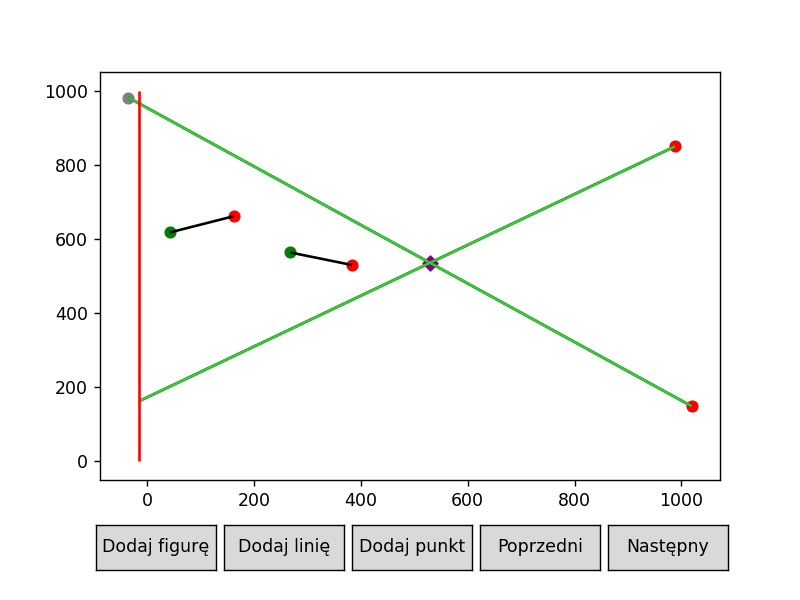

Czy występuje jakiekolwiek przecięcie:
True


In [15]:
%matplotlib notebook
linie = zestaw1
val,sceny = anyIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()
print("Czy występuje jakiekolwiek przecięcie:")
print(val)

Program szukający wszystkich przecięć

C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys
C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration


<IPython.core.display.Javascript object>


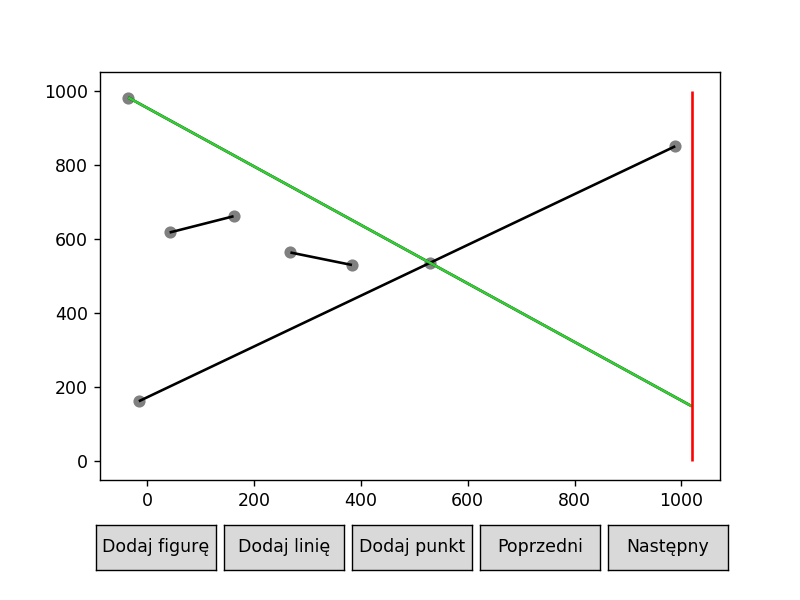

liczba przecięć:  1
Punkty przecięcia:


,X,Y,ID Pierwszego odcinka,ID drugiego odcinka
0,529.334432,535.499446,0,1


In [17]:
linie = zestaw1
sceny,val = allIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()
print("liczba przecięć: ",len(val))
print("Punkty przecięcia:")
crossPointsTable(val)

#### zestaw 2
Sprawdza poprawność działania na dużej liczbie odcinków mających dużo przecięć

In [141]:
linesInTable(zestaw2)

,ID,współczynnik kierunkowy,b,punkt startu,punkt końca
0,0,0.798178,756.947228,"(12.835976385301166, 767.1926199221143)","(232.3924279982044, 942.4377179613302)"
1,1,1.044200,511.142237,"(12.835976385301166, 524.545561098585)","(409.81178283691406, 939.0676199221145)"
2,2,1.146874,248.800684,"(108.19887961110763, 372.8911493338791)","(578.3601699336883, 912.106835608389)"
3,3,1.297998,-136.506345,"(283.40049251433345, 231.34703168682023)","(815.6585570304625, 922.2171297260361)"
4,4,2.076483,-1039.919443,"(613.8440409014303, 234.71712972603592)","(970.9004925143335, 976.1386983534869)"
5,5,0.894608,-215.286454,"(303.3601699336883, 56.10193364760448)","(578.3601699336883, 302.1190905103496)"
6,6,1.056313,54.174076,"(81.58597638530117, 140.3543846279967)","(263.4408150949786, 332.44997286329084)"
7,7,1.569026,-1111.241339,"(722.5133957401399, 22.400953255447632)","(995.2956538046561, 450.4034042358399)"
8,8,1.785539,-1586.233566,"(906.5859763853013, 32.511247373094704)","(995.2956538046561, 190.90585521623194)"
9,9,1.228176,-626.203667,"(547.3117828369141, 45.99163952995747)","(871.1021054175593, 443.6632081574085)"


Program szukający jakich kolwiek przecięć

C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys


<IPython.core.display.Javascript object>


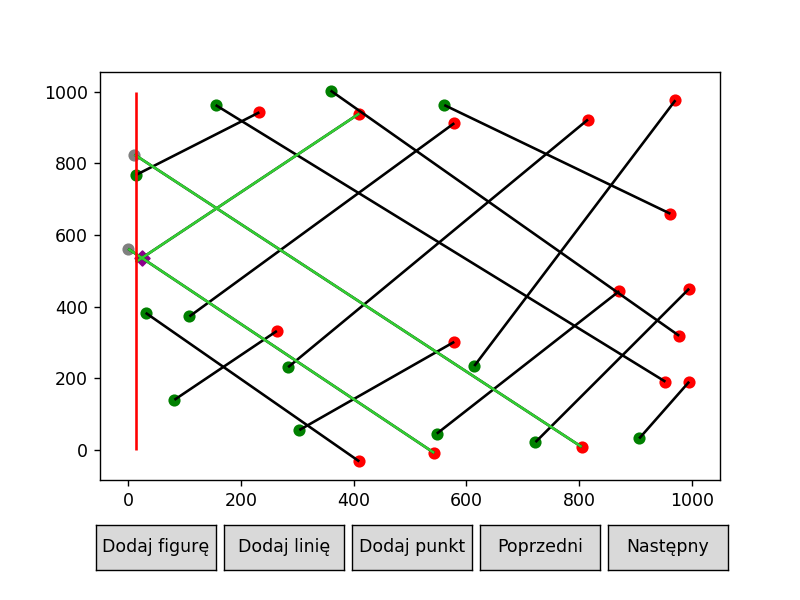

Czy występuje jakiekolwiek przecięcie:
True


In [152]:
linie = zestaw2
val,sceny = anyIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()
print("Czy występuje jakiekolwiek przecięcie:")
print(val)

C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys
C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration


<IPython.core.display.Javascript object>


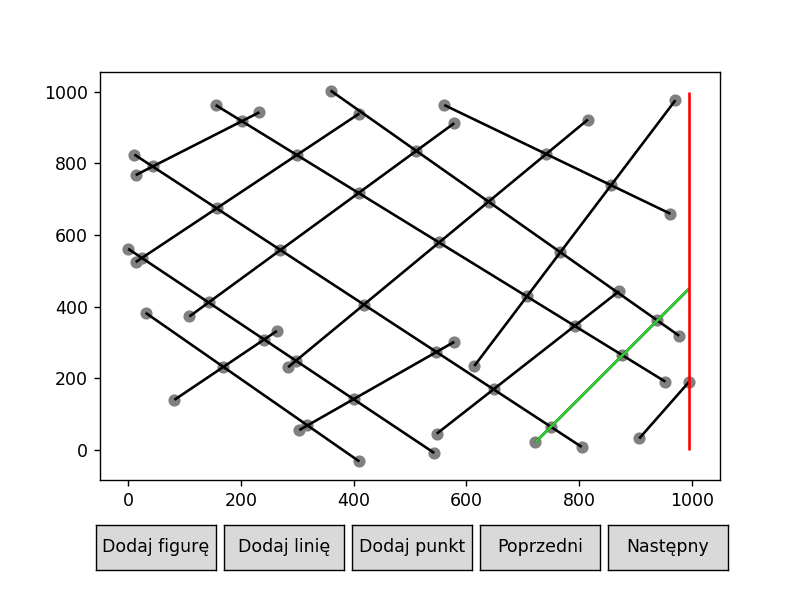

liczba przecięć:  28
Punkty przecięcia:


,X,Y,ID pierwszej prostej,ID drugiej prostej
0,399.628932,142.224724,5,12
1,639.158838,693.120783,3,14
2,876.893231,264.626927,10,7
3,938.821661,361.794241,7,14
4,510.985900,834.837048,2,14
5,546.707397,273.802271,11,5
6,297.342330,249.443513,3,12
7,168.538502,232.203447,6,13
8,792.080274,346.610475,10,9
9,856.676615,738.954785,4,15


In [153]:
linie = zestaw2
sceny,val = allIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()
print("liczba przecięć: ",len(val))
print("Punkty przecięcia:")
crossPointsTable(val)

#### Zestaw 3
Podobny do zestawu 1, ale sprawdza jeszcze wielokrotne przecięcia

In [14]:
linesInTable(zestaw3)

,ID,współczynnik kierunkowy,b,punkt startu,punkt końca
0,0,-0.833215,867.857937,"(17.27146025626891, 853.4670988718667)","(935.4166215465915, 88.45484396990594)"
1,1,1.024944,-7.233608,"(57.1908150949786, 51.383765538533396)","(908.8037183207852, 924.239157695396)"
2,2,0.636115,468.713081,"(101.54565380465604, 533.3077851463765)","(196.90855703046245, 593.969549852259)"
3,3,-1.100406,800.770971,"(212.43275057884958, 567.0087655385335)","(276.74726670788186, 496.236706715004)"
4,4,4.114060,-1913.256173,"(556.1827505788496, 374.91317730323925)","(647.1101699336883, 748.9940596561803)"
5,5,6.037361,-3586.028190,"(642.6746860627205, 294.0308243620628)","(724.7311376756238, 789.4352361267686)"
6,6,-0.833215,867.857937,"(17.27146025626891, 853.4670988718667)","(935.4166215465915, 88.45484396990594)"


C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys
C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration


<IPython.core.display.Javascript object>


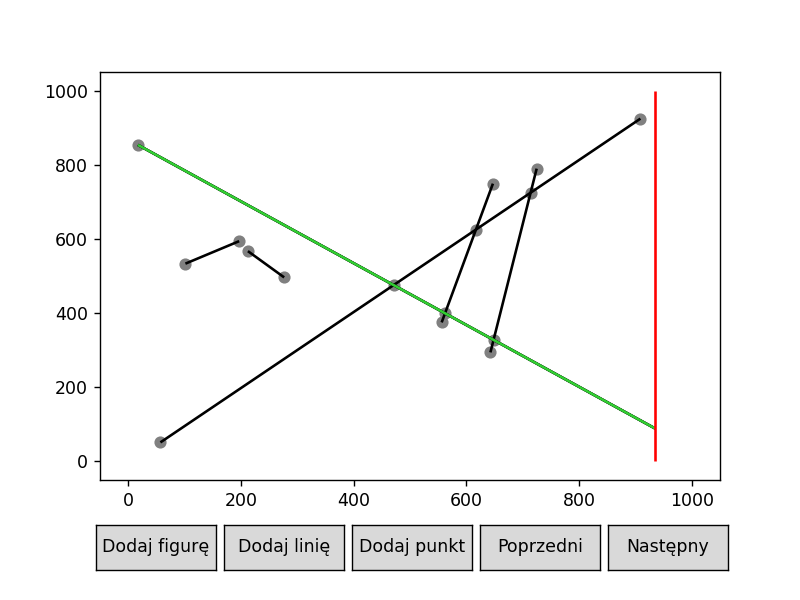

liczba przecięć:  5
Punkty przecięcia:


,X,Y,ID Pierwszego odcinka,ID drugiego odcinka
0,713.985796,724.561730,5,1
1,470.945521,475.459099,1,0
2,648.255146,327.722073,5,0
3,617.012214,625.169255,4,1
4,562.150680,399.465599,4,0


In [18]:
linie = zestaw3
sceny,val = allIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()
print("liczba przecięć: ",len(val))
print("Punkty przecięcia:")
crossPointsTable(val)

### Wprowadzanie odcinków


#### Prezentacja dostępnych sposobów wprowadzania odcinków
prezentacja wykonana na algorytmie sprawdzającym czy istnieją jakieś przecięcia

##### Ręczne wprowadzanie odcinków
- klikamy dodaj linię
- dodajemy krańce odcinków
- komórka poniżej wprowadzania pobiera wprowadzone odcinki,i szuka wszystkich punktów przecięć

<IPython.core.display.Javascript object>


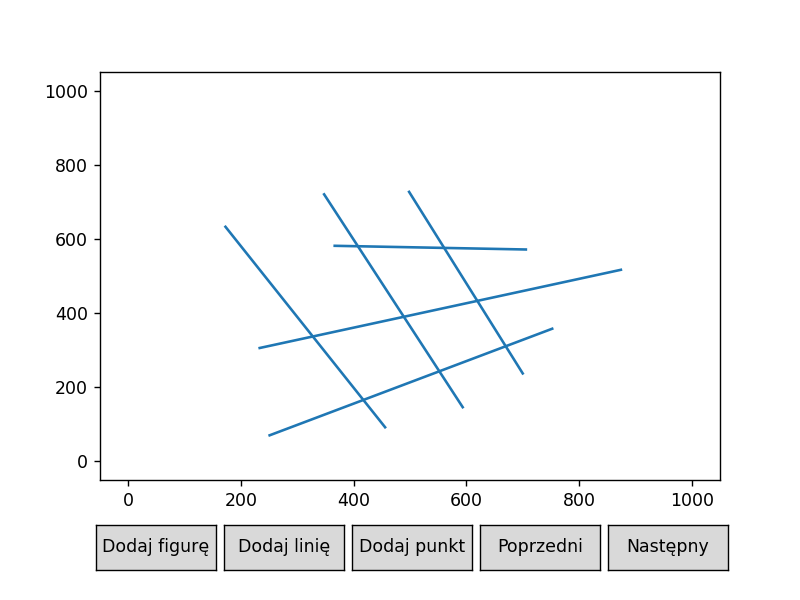

In [146]:
%matplotlib notebook
defaultPoints = PointsCollection(points=[(0,0),(1000,1000)],color="white",marker="s")
getingLines= Plot(points=[defaultPoints])
getingLines.draw()

In [147]:
linie = getLines(getingLines)
linesInTable(linie)

,ID,współczynnik kierunkowy,b,punkt startu,punkt końca
0,0,0.573185,-73.365398,"(248.80377246487527, 69.24529543109963)","(754.4489337551979, 359.07372680364875)"
1,1,-0.029412,592.209796,"(364.1263531100366, 581.5001973918841)","(707.8763531100366, 571.389903274237)"
2,2,0.328987,229.135756,"(231.0618369810043, 305.1521581761977)","(876.4247402068107, 517.4683346467859)"
3,3,-2.428069,1936.998275,"(497.1908692390689, 729.7845111173742)","(701.223127303585, 234.3800993526683)"
4,4,-2.333683,1531.395906,"(346.3844176261656, 723.0443150389428)","(594.7715144003591, 143.38745229384477)"
5,5,-1.908345,962.097570,"(171.18280472293978, 635.4217660193351)","(457.27151440035914, 89.46588366639378)"


C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys


<IPython.core.display.Javascript object>


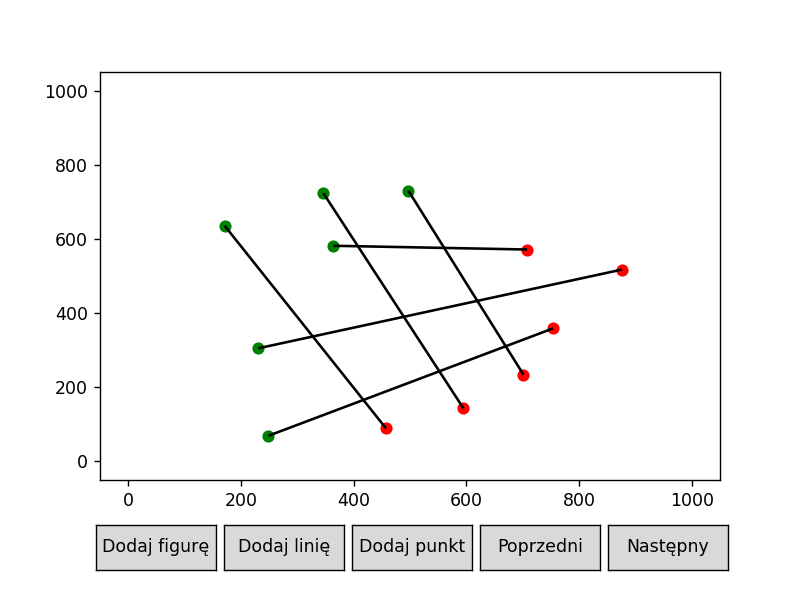

In [148]:
linie = getLines(getingLines)
val,sceny = anyIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()

In [115]:
#### Generowanie losowych odcinków

In [19]:
linie = generateLines(10,Vector2d(0,0),Vector2d(1000,1000))
linesInTable(linie)

,ID,współczynnik kierunkowy,b,punkt startu,punkt końca
0,0,-3.714299,3094.465779,"(668.516428268956, 611.3959588875538)","(832.8748541271764, 0.9196420198652744)"
1,1,0.203950,170.598482,"(129.89402965778396, 197.09039742560662)","(609.2489426726154, 294.85493535019856)"
2,2,-0.492280,852.395330,"(546.5821561522538, 583.3240637898432)","(806.2739268933173, 455.4830927123641)"
3,3,-2.612148,1715.425230,"(519.9401943029732, 357.2647005444908)","(646.332370236747, 27.10968174796802)"
4,4,-1.021908,471.796059,"(166.18646058828378, 301.9687786863782)","(447.8526865368044, 14.131797262391444)"
5,5,23.325476,-14417.568332,"(626.9576977297849, 206.5185162188412)","(659.9504515646905, 976.0902101371355)"
6,6,-0.765070,835.091271,"(564.7046344210038, 403.0525475984873)","(820.6697617297717, 207.221240034119)"
7,7,-0.193439,322.128449,"(27.346939988941333, 316.83848930856306)","(889.5310946474325, 150.05859619055138)"
8,8,3.397065,-2402.328238,"(732.7202099491228, 86.77016649396107)","(893.6155550050303, 633.3421612303016)"
9,9,0.999545,-98.840828,"(127.5453985020325, 28.64652906610199)","(670.9488059150467, 571.8026517303656)"


C:\Users\Kuba\.conda\envs\geometryczne\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator '_setmixin.__iter__' raised StopIteration
  import sys


<IPython.core.display.Javascript object>


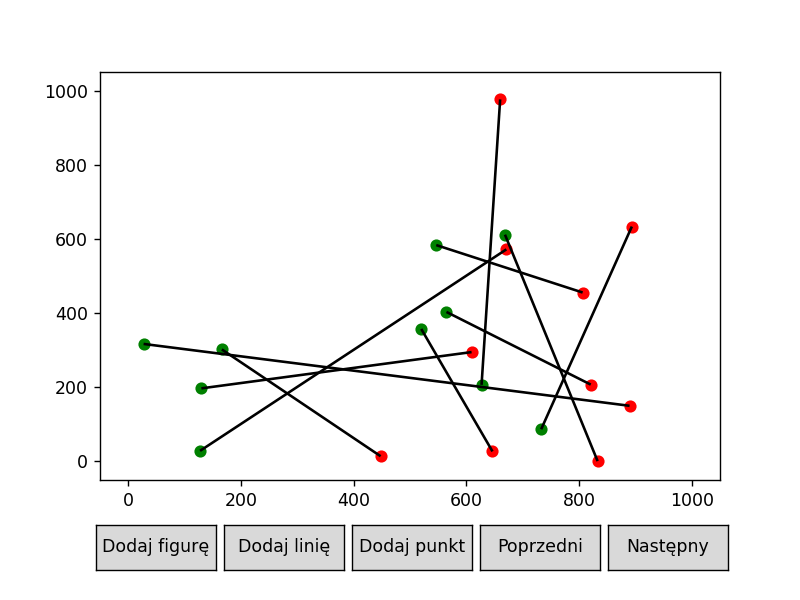

True


In [20]:
val,sceny = anyIntersect(linie)
plot = Plot(scenes = sceny)
plot.draw()
print(val)